In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

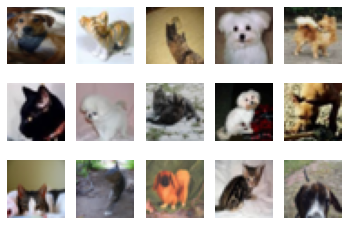

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print(f"Training examples:      {len(train_loader)}")
print(f"Validation examples:    {len(val_loader)}")
print(f"Test examples:          {len(test_loader)}")

Training examples:      8000
Validation examples:    2000
Test examples:          2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?



---

During training, weights are updated such that loss from the training data is minimized. However, if we only adjust the weights to minimize loss from the training data, the model overfits to the training data loses its ability to make predictions on data sets it has not yet encountered.

To make sure that our model works on data points it has not seen, we test its performance on the validation set to ensure that loss still remains low. The model's performance on the validation set (and at the very end, the testing set) will be a better indicator of its ability to generalize. 



## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
total = 0
for param in small_net.parameters():
    size = 1
    for dim in param.size():
        size = size * dim
    total += size
print(f"Total number of parameters in small_net:     {total}")

total = 0
for param in large_net.parameters():
    size = 1
    for dim in param.size():
        size = size * dim
    total += size
print(f"Total number of parameters in large_net:     {total}")

Total number of parameters in small_net:     386
Total number of parameters in large_net:     9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?



---
Default values: batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.


---
The following files are generated when training with small_net for 5 epochs:
*   _train_err.csv: training error
*   _train_loss.csv: training loss
*   _val_err.csv: validation error
*   _val_loss.csv: validation loss

As well, train_model will write saved values of the model weights at the end of each epoch (5 of these in total)


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.423, Train loss: 0.6713156499862671 |Validation err: 0.3725, Validation loss: 0.654650554060936
Epoch 2: Train err: 0.353125, Train loss: 0.6350869727134705 |Validation err: 0.358, Validation loss: 0.6433363892138004
Epoch 3: Train err: 0.343375, Train loss: 0.6218686904907227 |Validation err: 0.356, Validation loss: 0.6277994383126497
Epoch 4: Train err: 0.33075, Train loss: 0.6121090955734253 |Validation err: 0.3805, Validation loss: 0.6446056254208088
Epoch 5: Train err: 0.324625, Train loss: 0.601798137664795 |Validation err: 0.328, Validation loss: 0.619052005931735
Epoch 6: Train err: 0.313625, Train loss: 0.5917123095989227 |Validation err: 0.3315, Validation loss: 0.6144127789884806
Epoch 7: Train err: 0.307125, Train loss: 0.5879993503093719 |Validation err: 0.3275, Validation loss: 0.6063541937619448
Epoch 8: Train err: 0.3065, Train loss: 0.5800212597846985 |Validation err: 0.3145, Validation loss: 0.5978703908622265
Epoch 9: Train err: 0.302625, Train 

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466625, Train loss: 0.6913474893569946 |Validation err: 0.443, Validation loss: 0.6857451852411032
Epoch 2: Train err: 0.435375, Train loss: 0.6810451159477234 |Validation err: 0.4085, Validation loss: 0.6732319314032793
Epoch 3: Train err: 0.39875, Train loss: 0.662408887386322 |Validation err: 0.379, Validation loss: 0.6443073004484177
Epoch 4: Train err: 0.361, Train loss: 0.6382045469284058 |Validation err: 0.3485, Validation loss: 0.6344144660979509
Epoch 5: Train err: 0.341375, Train loss: 0.6227920763492584 |Validation err: 0.327, Validation loss: 0.6200453788042068
Epoch 6: Train err: 0.331625, Train loss: 0.6055357272624969 |Validation err: 0.326, Validation loss: 0.614756366237998
Epoch 7: Train err: 0.318375, Train loss: 0.5922387337684631 |Validation err: 0.3085, Validation loss: 0.5977270156145096
Epoch 8: Train err: 0.3085, Train loss: 0.5804160313606263 |Validation err: 0.31



---

Small net time: 114.78s

Large net time: 131.21s

Large net takes longer because there are more parameters.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

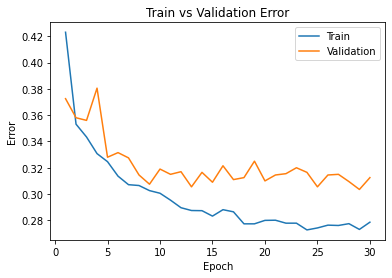

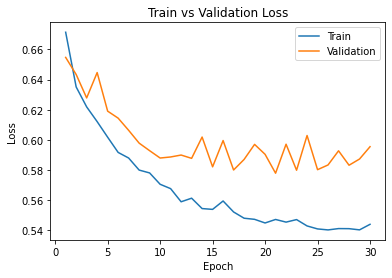

In [ ]:
path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(path)

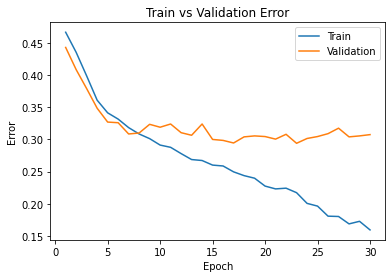

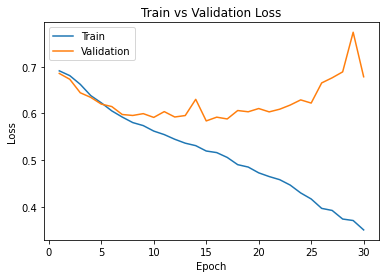

In [ ]:
path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.



---
It can be observed that when using large_net, the training loss decreases as the number of epochs increases. It can also be observed that the validation loss decreases initially using large_net, however increases past approximately 15 epochs. As large_net has more parameters to train, it is more complex and is more capable of overfitting to the training data. This is observed by the downward trend of loss curve in training set but _not_ validation set, signifying that the model is becoming only effective making predictions on data it has already seen rather than fresh data.

This does not occur when using small_net, as both validation and training loss exhibit a general downward trend. It can be noted however, that the training loss using small_net is larger than that of the large_net. As small_net is less complex, as there are less paramters to train. As a result, the model underfits to the data in comparison to large_net, thus resulting in a slightly larger training loss.



## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

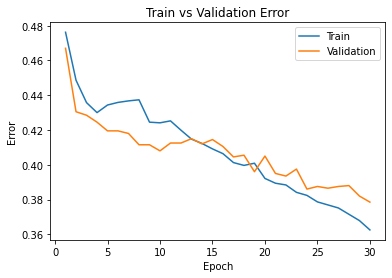

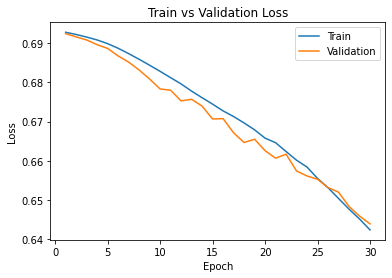

In [ ]:
path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(path)



---



Lowering the learning rate increases the time needed for training, as the weights are updated at a slower rate. However, with a lower learning rate, it is more likely that the model can find the weights that result in a local (or global) minimum training loss. Thus, yielding better performance from the model when generalizing against new data sets.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

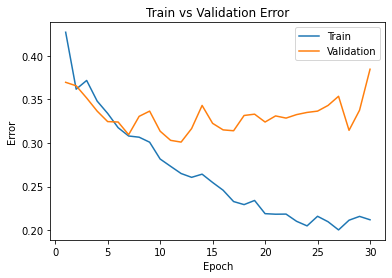

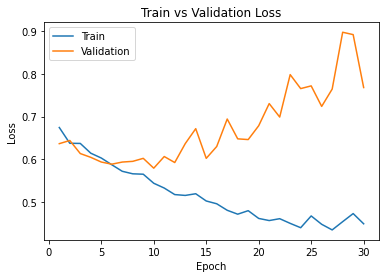

In [ ]:
path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(path)



---

Increasing the learning rate decreases the time needed to train, as the model's parameters are updated at a faster rate. However, this risks the model from finding weights that result in a local (or gloabl) minimum for training loss, as it may update the weights too drastically and "skip" over an optimal weight that allows the model to better generalize (as seen by the increasing validation loss).

In this case, although a higher learning rate results in lower training loss, it produces a higher validation loss compared to a lower learning rate of 0.001.


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

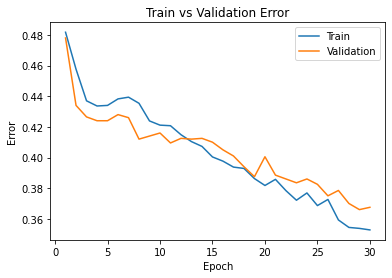

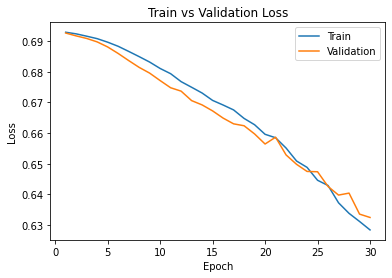

In [ ]:
path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(path)



---



A larger batch size means that less training iterations need to be made per epoch, thus resulting in less time needed for training.

Since for each iteration, the optimizer is minimizing the average loss over a large number of data, weight updates are less sensitive to each data point. Comparing the loss curves, we see that the larger batch results in a slightly smoother curve.

As well, it can be observed in this case, a larger batch results in better generalization in the validation set.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

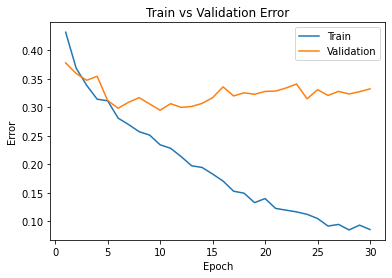

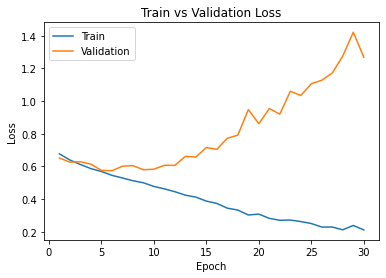

In [ ]:
path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(path)



---


A smaller batch size means that more training iterations need to be made per epoch, thus resulting in more time needed for training.

Since for each iteration, the optimizer is minimizing the average loss over a smaller number of data, weight updates are more sensitive to each data point. Comparing the loss curves, we see that the smaller batch results in a slightly more jagged curve.

As well, it can be observed in this case, the smaller batch results in worse generalization in the validation set.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.



---
> NETWORK: large_net

Choose large_net since it has better ability to fit to the training data and reduce loss than small_net.



> BATCH SIZE: 512

From above, it can be observed that a largest batch size results in the lowest validation loss, which indicates better model performance against new data samples.



> LEARNING RATE: 0.001

From above, it can be observed that a smaller learning rate results in lower validation loss, which indicates better model performance against new data samples.





### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.6929955184459686 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280459880829 |Validation err: 0.493, Validation loss: 0.6929539293050766
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706467151642
Epoch 5: Train err: 0.473375, Train loss: 0.6927744224667549 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896125078201 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203668117523 |Validation err: 0.47, Validation loss: 0.6925524771213531
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463

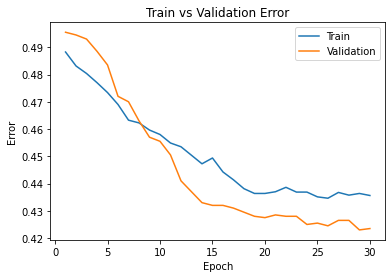

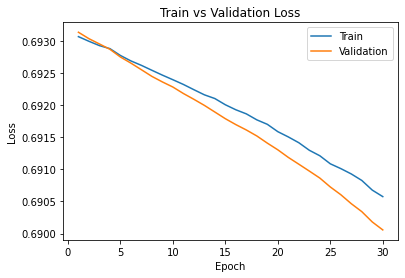

In [ ]:
path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

---
> NETWORK: small_net

Less complex, so it is less likely to overfit. It may produce better validation loss results although training loss may be higher.

> BATCH SIZE: 16

Weight update is more sensitive to the loss of each training data input. It may produce more noisy loss curves but may train the model better.


> LEARNING RATE: 0.001

From above, it can be observed that a smaller learning rate results in lower validation loss, which indicates better model performance against new data samples.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=16, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4495, Train loss: 0.6879159196615219 |Validation err: 0.424, Validation loss: 0.6807128019332885
Epoch 2: Train err: 0.421875, Train loss: 0.6765952432155609 |Validation err: 0.407, Validation loss: 0.6729811882972717
Epoch 3: Train err: 0.389625, Train loss: 0.6633437609672547 |Validation err: 0.3765, Validation loss: 0.6548554339408874
Epoch 4: Train err: 0.3765, Train loss: 0.6486893309354782 |Validation err: 0.382, Validation loss: 0.6466029353141785
Epoch 5: Train err: 0.35075, Train loss: 0.6345134264826775 |Validation err: 0.354, Validation loss: 0.6321161205768585
Epoch 6: Train err: 0.3425, Train loss: 0.6225107015371323 |Validation err: 0.3485, Validation loss: 0.6263759458065032
Epoch 7: Train err: 0.336125, Train loss: 0.6137455697059632 |Validation err: 0.342, Validation loss: 0.620362012386322
Epoch 8: Train err: 0.326375, Train loss: 0.6064395679831505 |Validation err: 0.34,

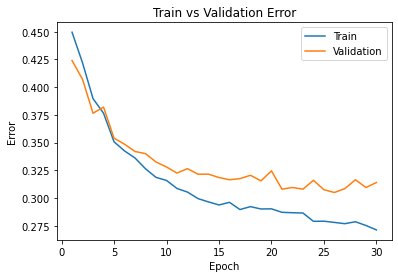

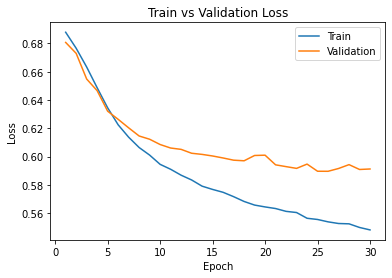

In [ ]:
path = get_model_name("small", batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

### Part (b) - 2pt

Justify your choice of model from part (a).



---

I chose to use small_net as it is less complex and less likely to overfit. However, I chose to use smaller batch size (16) and a lower learning rate (0.001) to update the weights more "granularly". The weight updates will be more sensitive to the loss of each training data point, and will be updated less drastically to avoid "skipping over" local/global training loss minimums.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

err, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print(f"Test classification err:    {err}")

Files already downloaded and verified
Files already downloaded and verified
Test classification err:    0.2875


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.



---


*   Test error: 0.2875
*   Validation error: 0.314

In this case, the test error is lower than the validation error. This means that for this particular testing data set, the model's preformance was better than with the validation data set.

Generally, it is expected that the test error is higher than the validation error because hyperparameters are tuned to minimize both training loss/error and validation loss/error. Therefore, by tuning the hyperparameters while having knowledge of the validation error/loss, it is possible that the model is overfitted to those two data sets. The model's performance against the testing set will be a more accurate measure of the model's performance against never-before-seen data.  

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?



---
The test data set is only used at the very end to get a sense of the model's true ability to make predictions without having seen the input beforehand. It is important to use the data set as little as possible because we need to avoid tuning hyperparameters and changing the model to fit the testing data, and at that point it won't be a true measure of how well the model performs.


### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 64)
        self.layer2 = nn.Linear(64, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

In [ ]:
pigeon = Pigeon()
train_net(pigeon)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.408125, Train loss: 0.6616947374343872 |Validation err: 0.3855, Validation loss: 0.6489066779613495
Epoch 2: Train err: 0.36975, Train loss: 0.6367153573036194 |Validation err: 0.3995, Validation loss: 0.6575264558196068
Epoch 3: Train err: 0.347125, Train loss: 0.623867021560669 |Validation err: 0.3755, Validation loss: 0.6418185289949179
Epoch 4: Train err: 0.337625, Train loss: 0.6130258169174194 |Validation err: 0.396, Validation loss: 0.6713699158281088
Epoch 5: Train err: 0.32425, Train loss: 0.5981384961605072 |Validation err: 0.38, Validation loss: 0.6472211796790361
Epoch 6: Train err: 0.302375, Train loss: 0.5789207644462585 |Validation err: 0.3775, Validation loss: 0.6571633107960224
Epoch 7: Train err: 0.297375, Train loss: 0.5684410207271576 |Validation err: 0.3755, Validation loss: 0.6571356412023306
Epoch 8: Train err: 0.27975, Train loss: 0.5471755135059356 |Validation err:

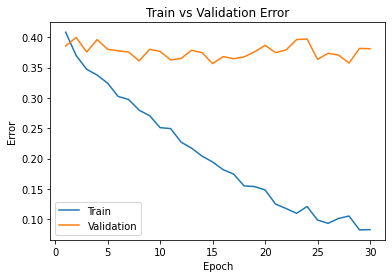

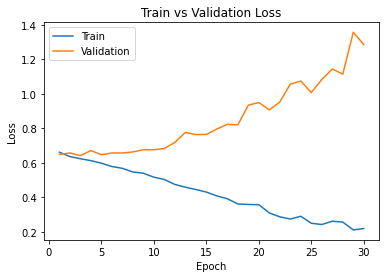

In [ ]:
path = get_model_name("pigeon", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(path)

In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.449375, Train loss: 0.6834945231676102 |Validation err: 0.4155, Validation loss: 0.6704004555940628
Epoch 2: Train err: 0.40125, Train loss: 0.6628331132233143 |Validation err: 0.404, Validation loss: 0.6594875752925873
Epoch 3: Train err: 0.387375, Train loss: 0.6520894467830658 |Validation err: 0.391, Validation loss: 0.6559617817401886
Epoch 4: Train err: 0.3755, Train loss: 0.6454806141555309 |Validation err: 0.3875, Validation loss: 0.651724711060524
Epoch 5: Train err: 0.3695, Train loss: 0.6386899538338184 |Validation err: 0.3805, Validation loss: 0.6488701105117798
Epoch 6: Train err: 0.36175, Train loss: 0.63443673402071 |Validation err: 0.383, Validation loss: 0.6492208391427994
Epoch 7: Train err: 0.354875, Train loss: 0.6297479160130024 |Validation err: 0.381, Validation loss: 0.6469717025756836
Epoch 8: Train err: 0.35075, Train loss: 0.6241599582135677 |Validation err: 0.378,

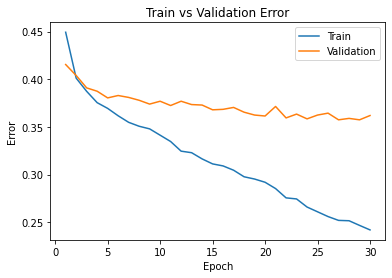

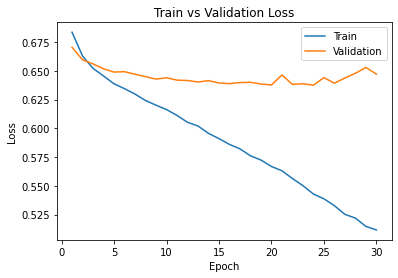

In [ ]:
path = get_model_name("pigeon", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(path)

In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.403375, Train loss: 0.6669580099582673 |Validation err: 0.392, Validation loss: 0.651327935218811
Epoch 2: Train err: 0.381625, Train loss: 0.6511198070645332 |Validation err: 0.3975, Validation loss: 0.6560315485000611
Epoch 3: Train err: 0.36625, Train loss: 0.6406792113184929 |Validation err: 0.3965, Validation loss: 0.6570471086502075
Epoch 4: Train err: 0.353125, Train loss: 0.6267688404321671 |Validation err: 0.394, Validation loss: 0.6619169993400573
Epoch 5: Train err: 0.335875, Train loss: 0.6225823013186454 |Validation err: 0.376, Validation loss: 0.6543874480724334
Epoch 6: Train err: 0.321125, Train loss: 0.600096373796463 |Validation err: 0.4105, Validation loss: 0.6830261445045471
Epoch 7: Train err: 0.3085, Train loss: 0.594404832482338 |Validation err: 0.3745, Validation loss: 0.6762849698066712
Epoch 8: Train err: 0.293375, Train loss: 0.5808380718827247 |Validation err: 0

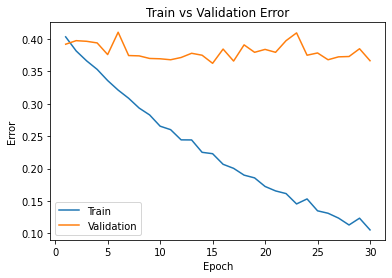

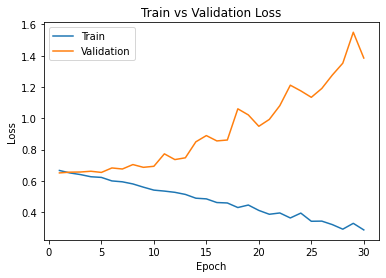

In [ ]:
path = get_model_name("pigeon", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(path)

In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=16, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.409625, Train loss: 0.6650054975748062 |Validation err: 0.392, Validation loss: 0.6522388243675232
Epoch 2: Train err: 0.377, Train loss: 0.6431385068297386 |Validation err: 0.386, Validation loss: 0.6509417159557342
Epoch 3: Train err: 0.362125, Train loss: 0.632765799164772 |Validation err: 0.375, Validation loss: 0.6422865400314332
Epoch 4: Train err: 0.348625, Train loss: 0.6222353457808495 |Validation err: 0.3935, Validation loss: 0.6543270297050476
Epoch 5: Train err: 0.336875, Train loss: 0.6138497440218925 |Validation err: 0.378, Validation loss: 0.639101301908493
Epoch 6: Train err: 0.3235, Train loss: 0.6011370244622231 |Validation err: 0.389, Validation loss: 0.6547720313072205
Epoch 7: Train err: 0.31375, Train loss: 0.5914073291420937 |Validation err: 0.3675, Validation loss: 0.640618255853653
Epoch 8: Train err: 0.30875, Train loss: 0.5802214931845665 |Validation err: 0.3665,

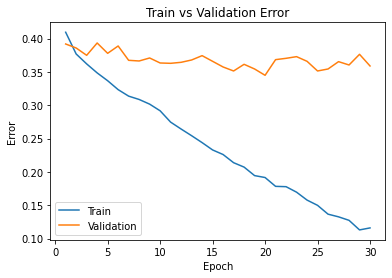

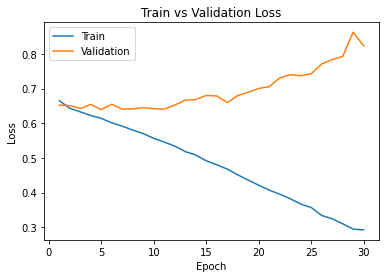

In [ ]:
path = get_model_name("pigeon", batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(path)

In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.429625, Train loss: 0.678660439491272 |Validation err: 0.4135, Validation loss: 0.6666923146694899
Epoch 2: Train err: 0.39625, Train loss: 0.6606415429115295 |Validation err: 0.399, Validation loss: 0.6590037383139133
Epoch 3: Train err: 0.384875, Train loss: 0.6522809295654297 |Validation err: 0.3905, Validation loss: 0.6547982078045607
Epoch 4: Train err: 0.379375, Train loss: 0.6459718060493469 |Validation err: 0.3915, Validation loss: 0.6526721213012934
Epoch 5: Train err: 0.370625, Train loss: 0.6413468680381775 |Validation err: 0.3805, Validation loss: 0.6499994918704033
Epoch 6: Train err: 0.364, Train loss: 0.6360033240318298 |Validation err: 0.3835, Validation loss: 0.648164426907897
Epoch 7: Train err: 0.359625, Train loss: 0.632028826713562 |Validation err: 0.377, Validation loss: 0.6469521466642618
Epoch 8: Train err: 0.351375, Train loss: 0.6280057492256165 |Validation err: 0

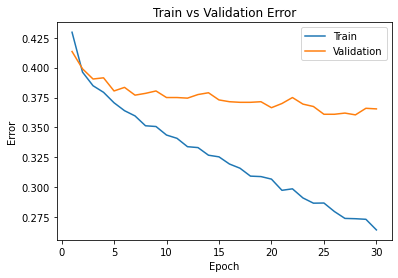

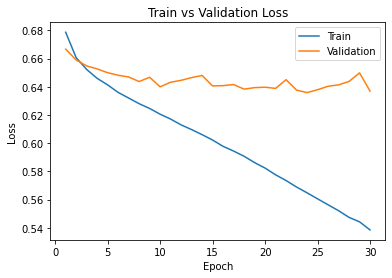

In [ ]:
path = get_model_name("pigeon", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(path)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

err, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print(f"CNN test err:    {err}")


net = Pigeon()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

err, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print(f"ANN test err:    {err}")

Files already downloaded and verified
Files already downloaded and verified
CNN test err:    0.2875
Files already downloaded and verified
Files already downloaded and verified
ANN test err:    0.35




---
CNN performs better than ANN in terms of test and validation error and loss. The best hyperparameters for ANN is:


*   batch_size=512, learning_rate=0.01, num_epochs=30

Comparing the test error of ANN and CNN, we see that CNN yields a lower error than ANN.

